# PREDICTING SEPSIS RISK DURING IN-PATIENT ADMISSIONS
*Client: Royal Perth Hospital*

*Team: Group 7*

# PART I. Traditional (Static) Machine Learning Models

## 1. Loading necessary libraries

In [1]:
import pandas as pd
import numpy as np, warnings
from pathlib import Path
import os
import sweetviz as sv
from importlib import reload
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

np.warnings = warnings

In [95]:
import sys
sys.path.append("..")

# import utility functions
import src.utils as util
reload(util)

# setup OS agnostic pathnames
ROOT_DIR = Path('..')

# Note: to run main notebook from root directory, use:
# ROOT_DIR = Path('')

import src.DataLoader as DataLoader
reload(DataLoader)

dataLoader = DataLoader.DataLoader(ROOT_DIR)

import src.modelling_pipeline as models
reload(models)

mp = models.ModelPipeline(ROOT_DIR)

# import src.utils as util
# reload(util)

# mp = util.util(ROOT_DIR)

In [3]:
# load libraries and modules
import pandas as pd
import numpy as np
import shap

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import SelectFromModel

# model comparison
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# evaluation metrics
from sklearn.metrics import cohen_kappa_score,classification_report 
from sklearn.metrics import mean_squared_error, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, auc, make_scorer
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, balanced_accuracy_score
from sklearn.metrics import PrecisionRecallDisplay

## 2. Loading Data

In [4]:
df_desc_icd, df_desc_labitems, df_desc_items = dataLoader.load_descriptions()
df_diagnoses_icd = dataLoader.load_diagnoses_icd(df_desc_icd)
df_demographic = dataLoader.load_demographic(df_diagnoses_icd)
df_demographic = dataLoader.demographic_clean_AGE(df_demographic)
df_labevents = dataLoader.load_labevents(df_demographic)
df_labevents = dataLoader.labevents_compute_TIME(df_labevents, df_demographic)

Removed 8210 admissions with AGE < 18


## 3. Dataset Extraction

In [24]:
hours_list = [0, 1, 2, 3, 4, 5, 6, 7, 8]
top_n_features = [10, 20, 30, 40]

In [49]:
dfs_dict = {}
for top_n in top_n_features:
  dfs_dict[f'top{top_n}'] = {}
  for hour in hours_list:
    feature_filename=ROOT_DIR / 'data/potential_events.csv'
    output_filename = ROOT_DIR / f'data/full_data/t{hour}_top{top_n}.csv'
    dfs_dict[f'top{top_n}'][f't{hour}']=dataLoader.extract_full_data_by_features(df_labevents, df_demographic, df_desc_labitems, hour, feature_filename, top_n, output_filename)


## 4. Data processing

### 4.1 Missing values

In [10]:
# Number and proportion of missing values in overall dataset
mp.count_missing_values_all(dfs_dict, hours_list, top_n_features)

top10_features_NA_Count top10_features_NA_% top20_features_NA_Count  \
t0                  337938              39.19%                  655171   
t1                  281873              32.70%                  552885   
t2                  252276              29.27%                  501521   
t3                  229446              26.63%                  461332   
t4                  209346              24.31%                  425678   
t5                  191785              22.28%                  393840   
t6                  177380              20.63%                  366778   
t7                  165824              19.31%                  344198   
t8                  156133              18.21%                  325172   

   top20_features_NA_% top30_features_NA_Count top30_features_NA_%  \
t0              49.68%                 1022882              56.02%   
t1              41.93%                  881229              48.27%   
t2              38.05%                  808140              44.28%   
t3              35.01%                  751050              41.17%   
t4              32.32%                  701282              38.46%   
t5              29.92%                  657403              36.07%   
t6              27.89%                  620056              34.05%   
t7              26.21%                  588585              32.37%   
t8              24.80%                  561948              30.95%   

   top40_features_NA_Count top40_features_NA_%  
t0                 1368814              59.97%  
t1                 1194105              52.33%  
t2                 1104934              48.43%  
t3                 1035111              45.39%  
t4                  974102              42.74%  
t5                  920375              40.40%  
t6                  874361              38.42%  
t7                  835039              36.74%  
t8                  801458              35.32%

From the above, we have computed the number and proportion of missing values in the dataset across different number of top features (from 10 to 40) in t0 to t8. We will further analyse the number and proportion of missing values specific to sepsis admissions.

In [11]:
# Number and proportion of missing values in sepsis admission
mp.count_missing_values_all(dfs_dict, hours_list, top_n_features, sepsis_only=True)

top10_features_NA_Count top10_features_NA_% top20_features_NA_Count  \
t0                   26940              30.64%                   55627   
t1                   18263              20.78%                   39379   
t2                   14761              16.80%                   33233   
t3                   12407              14.13%                   28999   
t4                   10772              12.28%                   25963   
t5                    9605              10.95%                   23594   
t6                    8706               9.93%                   21617   
t7                    7969               9.10%                   19884   
t8                    7265               8.31%                   18297   

   top20_features_NA_% top30_features_NA_Count top30_features_NA_%  \
t0              41.37%                   89066              47.84%   
t1              29.29%                   67062              36.02%   
t2              24.73%                   58291              31.33%   
t3              21.59%                   52140              28.04%   
t4              19.34%                   47657              25.65%   
t5              17.58%                   44081              23.73%   
t6              16.13%                   41081              22.13%   
t7              14.85%                   38471              20.75%   
t8              13.68%                   36091              19.49%   

   top40_features_NA_Count top40_features_NA_%  
t0                  120444              51.75%  
t1                   93738              40.28%  
t2                   83045              35.70%  
t3                   75523              32.49%  
t4                   69909              30.10%  
t5                   65349              28.14%  
t6                   61368              26.45%  
t7                   57893              24.99%  
t8                   54731              23.65%

From the above, we can observe for sepsis admissions there is significant decrease in missing values from t0 to t1 (approximately 10% decrease), which is likely due to the patients receive their first blood test within an hour. This finding is align to the findings on the mean of first blood test performed in sepsis admissions to be 0.84 hours.

As at t4, there are less than 30% of missing values observed in the sepsis admissions. We believe focusing our traditional ML mdoel training to predict sepsis within 4 hours after admission is reasonable. 

In [20]:
def filter_missing_rows(df, proportion_to_return):
    """
    Filters rows in a DataFrame based on a threshold of missing or masked values.

    This function checks each row in the input DataFrame for missing or masked values. 
    Missing values are identified as NaN, while masked values are represented as -999. 
    The function calculates the percentage of missing or masked values in each row. 
    Rows with a percentage of missing or masked values less than or equal to the specified 
    'proportion_to_return' are retained in the returned DataFrame.

    Parameters:
    df (pd.DataFrame): The input DataFrame with potential missing or masked values.
    proportion_to_return (float): The threshold percentage (0-100) of allowable missing or 
                                   masked values per row. Rows with a percentage of missing 
                                   or masked values within this threshold are returned.

    Returns:
    pd.DataFrame: A DataFrame consisting of rows from the input DataFrame that have a 
                  percentage of missing or masked values less than or equal to the 
                  'proportion_to_return'. If no masking is present, the function checks 
                  for NaN values instead.
    """
    # Check if masking has been applied
    if (df == -999).any().any():  # Masking is present
        count_missing = (df == -999).sum(axis=1)
    else:  # No masking, check for NaN
        count_missing = df.isna().sum(axis=1)

    # Calculate the percentage of missing values for each row
    p_missing = count_missing / df.shape[1] * 100

    # Filter rows based on the allowed proportion of missing/masked values
    return df[p_missing <= proportion_to_return]

In [51]:
# Iterate through all dataframes in dfs_dict and update them
dfs_dict_without_missing = {}
for key in dfs_dict.keys():
    dfs_dict_without_missing[key] = {}
    for subkey in dfs_dict[key].keys():
        dfs_dict_without_missing[key][subkey] = filter_missing_rows(dfs_dict[key][subkey], 70)
        dfs_dict_without_missing[key][subkey]= dfs_dict_without_missing[key][subkey].drop(['SUBJECT_ID', 'HADM_ID'], axis=1)

### 4.2 Feature scales

Understanding different features are having different scale of measurement, we will standardise all the feature scales using StandardScaler to avoid any potential bias towards features with larger magnitute scales. The feature standardisation will be done in Section 5's split_data function.

### 4.3 Training and Test set split

80/20 training and test set split will be performed in this traditional ML model training. It will be done in Section 5's split_data function.

## 5. Model Fitting

In this section, we fitted all three traditional (static) Machine Learning algorithms for different top features (top 10 features to top 40 features) and time windows (t0 to t4). We then evaluated and compared the performance of all the models to search for the best combination of traditional machine learning algorithm, top features extraction, and time window.

In [14]:
top_features = ['top10', 'top20', 'top30', 'top40'] 
time_windows = ['t0', 't1', 't2', 't3', 't4']

In [53]:
split_data_dict = {} # Dictionary to store split datasets
models_dict = {}  # Dictionary to store candidate models for each top and time
performance_dict = {}
consolidated_performance = {}
all_performance_dfs = []

for top in top_features:
    performance_dict[top] = {}
    models_dict[top] = {}  # Initialize a sub-dictionary for this top value
    dfs_list = []
    
    for time in time_windows:
        # Split data
        X_train, X_test, y_train, y_test = mp.split_data(dfs_dict_without_missing[top][time])
        
        # Store split data
        split_data_dict[(top, time)] = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}
        
        # Get class weights
        current_class_weights = mp.get_class_weights(y_train)
        
        # Initialize models
        candidate_models = {
            'Logistic_Regression': LogisticRegression(max_iter=10000000000, class_weight=current_class_weights, C=0.1, penalty=None, random_state=901),
            'Random_Forest': RandomForestClassifier(class_weight=current_class_weights, max_depth=7, min_samples_leaf=25, min_samples_split=250, random_state=901),
            'Gradient_Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=901)
        }

        # Store candidate models
        models_dict[top][time] = candidate_models
        
        # Compute performance
        performance_df = mp.static_models(candidate_models, current_class_weights, X_train, y_train, X_test, y_test, time)
        performance_df['top_features'] = top

        # Store performance
        performance_dict[top][time] = performance_df
        
        # Append to the list
        dfs_list.append(performance_df)
    
    # Concatenate and sort for this top value
    consolidated_df = pd.concat(dfs_list)
    consolidated_df = consolidated_df.sort_values(by='Model')
    consolidated_df.reset_index(drop=True, inplace=True)
    
    # Append to the all_dfs list
    all_performance_dfs.append(consolidated_df)

#concatenate all the dataframes into one
all_performance_df = pd.concat(all_performance_dfs, ignore_index=True)
all_performance_df = all_performance_df[['top_features'] + [col for col in all_performance_df.columns if col != 'top_features']]

Setting penalty=None will ignore the C and l1_ratio parameters
The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
Setting penalty=None will ignore the C and l1_ratio parameters
The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
Setting penalty=None will ignore the C and l1_ratio parameters
The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries bef

## 6. Model Evaluation

In [22]:
all_performance_df

top_features                   Model  Balanced_Acc_Train  \
0         top10    Gradient_Boosting_t0            0.560945   
1         top10    Gradient_Boosting_t1            0.557429   
2         top10    Gradient_Boosting_t2            0.566528   
3         top10    Gradient_Boosting_t3            0.559590   
4         top10    Gradient_Boosting_t4            0.560878   
5         top10  Logistic_Regression_t0            0.642489   
6         top10  Logistic_Regression_t1            0.648852   
7         top10  Logistic_Regression_t2            0.653882   
8         top10  Logistic_Regression_t3            0.645229   
9         top10  Logistic_Regression_t4            0.652378   
10        top10        Random_Forest_t0            0.740297   
11        top10        Random_Forest_t1            0.738618   
12        top10        Random_Forest_t2            0.742136   
13        top10        Random_Forest_t3            0.738878   
14        top10        Random_Forest_t4            0.745479   
15        top20    Gradient_Boosting_t0            0.571939   
16        top20    Gradient_Boosting_t1            0.605502   
17        top20    Gradient_Boosting_t2            0.601914   
18        top20    Gradient_Boosting_t3            0.594441   
19        top20    Gradient_Boosting_t4            0.591945   
20        top20  Logistic_Regression_t0            0.655557   
21        top20  Logistic_Regression_t1            0.718294   
22        top20  Logistic_Regression_t2            0.722536   
23        top20  Logistic_Regression_t3            0.717669   
24        top20  Logistic_Regression_t4            0.721126   
25        top20        Random_Forest_t0            0.747879   
26        top20        Random_Forest_t1            0.769983   
27        top20        Random_Forest_t2            0.772519   
28        top20        Random_Forest_t3            0.769046   
29        top20        Random_Forest_t4            0.772068   
30        top30    Gradient_Boosting_t0            0.577090   
31        top30    Gradient_Boosting_t1            0.610874   
32        top30    Gradient_Boosting_t2            0.606094   
33        top30    Gradient_Boosting_t3            0.600670   
34        top30    Gradient_Boosting_t4            0.599171   
35        top30  Logistic_Regression_t0            0.656922   
36        top30  Logistic_Regression_t1            0.714957   
37        top30  Logistic_Regression_t2            0.722637   
38        top30  Logistic_Regression_t3            0.719244   
39        top30  Logistic_Regression_t4            0.722531   
40        top30        Random_Forest_t0            0.745488   
41        top30        Random_Forest_t1            0.770713   
42        top30        Random_Forest_t2            0.776783   
43        top30        Random_Forest_t3            0.777753   
44        top30        Random_Forest_t4            0.773931   
45        top40    Gradient_Boosting_t0            0.594912   
46        top40    Gradient_Boosting_t1            0.631002   
47        top40    Gradient_Boosting_t2            0.626489   
48        top40    Gradient_Boosting_t3            0.617483   
49        top40    Gradient_Boosting_t4            0.618932   
50        top40  Logistic_Regression_t0            0.690663   
51        top40  Logistic_Regression_t1            0.733271   
52        top40  Logistic_Regression_t2            0.735697   
53        top40  Logistic_Regression_t3            0.731794   
54        top40  Logistic_Regression_t4            0.739140   
55        top40        Random_Forest_t0            0.761249   
56        top40        Random_Forest_t1            0.778459   
57        top40        Random_Forest_t2            0.779073   
58        top40        Random_Forest_t3            0.778277   
59        top40        Random_Forest_t4            0.781338   

    Balanced_Acc_Test  Precision_Train  Precision_Test  Recall_Train  \
0            0.559166         0.645439        0.613333      0.131395   
1            0.

From the above, we can observe:

- Traditional Machine Learning algorithm: Random Forest models were having the highest balanced accuracy, precision, and F1 scores, followed by Logistic Regression models and Gradient Boosting models.

- Top features: Models trained with top 40 features had the best performance. 

- Time window: Models trained in t3 had the best performance. 

However, our goal in the Traditional (static) ML model training is to fit a model which can use as fewer features and as early as it could to achieve a certain level of performance.

We will further perform 5-fold cross validation test on all 3 Traditional Machine Learning algorithms by:

- fixing features input to be top 40 features and compare the performance across different time windows

- fixing time window to be t4 (the upper limit of time window in Traditional Machine Learning models and with fewer missing values) and compare the performance across different top feature selection

In [24]:
# Compare models at top 40 features (5-fold cross validation)
top40_cv_results_df = mp.perform_cv_for_conditions(time_windows, [top_features[3]], split_data_dict, candidate_models, all_models=True)
top40_cv_results_df

Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio par

model  train_balanced_acc  cv_balanced_acc top_features  \
0   Logistic_Regression            0.690523         0.687402        top40   
1         Random_Forest            0.761255         0.731485        top40   
2     Gradient_Boosting            0.594912         0.570706        top40   
3   Logistic_Regression            0.733610         0.729364        top40   
4         Random_Forest            0.778466         0.753966        top40   
5     Gradient_Boosting            0.631002         0.606117        top40   
6   Logistic_Regression            0.735954         0.733942        top40   
7         Random_Forest            0.779429         0.754444        top40   
8     Gradient_Boosting            0.626489         0.607225        top40   
9   Logistic_Regression            0.731769         0.730174        top40   
10        Random_Forest            0.778509         0.754697        top40   
11    Gradient_Boosting            0.617483         0.598034        top40   
12  Logistic_Regression            0.739140         0.735307        top40   
13        Random_Forest            0.781338         0.757360        top40   
14    Gradient_Boosting            0.618932         0.596683        top40   

   time_window  
0           t0  
1           t0  
2           t0  
3           t1  
4           t1  
5           t1  
6           t2  
7           t2  
8           t2  
9           t3  
10          t3  
11          t3  
12          t4  
13          t4  
14          t4

From the above, we can observe there was relatively larger improvement in the average validated balanced accuarcy scores from t0 to t1 for each of the algorithm; however, the improvement has slowed down after t1. 

For Random Forest models, the average validated balanced accuarcy scores have remained in approximately 0.75; while for Gradient Boosing and Logistic Regression models, the average validated balanced accuarcy scores peaked at t2 and decreased at t3 and t4.

As a result, with the consideration on the performance of 3 algorithms, t2 is likely to be the most effective time window for our traditional (static) machine learning model training. 

In [26]:
# Compare models at t4 (5-fold cross validation)
t4_cv_results_df = mp.perform_cv_for_conditions([time_windows[4]], top_features, split_data_dict, candidate_models, all_models=True)
t4_cv_results_df

Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio par

model  train_balanced_acc  cv_balanced_acc top_features  \
0   Logistic_Regression            0.652930         0.652190        top10   
1         Random_Forest            0.745256         0.719317        top10   
2     Gradient_Boosting            0.560878         0.546320        top10   
3   Logistic_Regression            0.720719         0.720470        top20   
4         Random_Forest            0.772347         0.753654        top20   
5     Gradient_Boosting            0.591945         0.577219        top20   
6   Logistic_Regression            0.722616         0.720439        top30   
7         Random_Forest            0.773687         0.752560        top30   
8     Gradient_Boosting            0.599171         0.575933        top30   
9   Logistic_Regression            0.739140         0.735307        top40   
10        Random_Forest            0.781338         0.757360        top40   
11    Gradient_Boosting            0.618932         0.596683        top40   

   time_window  
0           t4  
1           t4  
2           t4  
3           t4  
4           t4  
5           t4  
6           t4  
7           t4  
8           t4  
9           t4  
10          t4  
11          t4

From the above, we can observe there was relatively larger improvement in the average validated balanced accuarcy scores from top10 to top20 features, then remained similar level at top30 features, and improved with a smaller extent at top40 features in each algorithm.

As a result, both top20 and top40 are appropriate to be the time window of traditional (static) machine learning model training.

However, our goal in the Traditional (static) ML model training is to fit a model which can using as fewer features and as early as it could to achieve a certain level of performance. We considered top20 was more appropriate given there was no significant difference in performance between top20 and top40.

## 7. Final Models

In [28]:
# Compare the model performance at t2 and top20 features (5-fold cross validation)
t2_top20_cv_results_df = mp.perform_cv_for_conditions([time_windows[2]], [top_features[1]], split_data_dict, candidate_models, all_models=True)
t2_top20_cv_results_df

Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters


model  train_balanced_acc  cv_balanced_acc top_features  \
0  Logistic_Regression            0.721128         0.720925        top20   
1        Random_Forest            0.772986         0.752088        top20   
2    Gradient_Boosting            0.601914         0.580571        top20   

  time_window  
0          t2  
1          t2  
2          t2

From the models trained at t2 with top20 features input, we can observe Random Forest algorithm performed the best with average validated balanced accuracy score of 0.752, followed by Logistic Regression of 0.721 and Gradient Boosting of 0.581.

Besides, there were no significant decrease in the validation balance accuracy score from the training balance accuracy score, which means there is no overfitting issues observed.

In the next stage, we further evaluated the top20 feature models at t3 with more performance matrices, such as precision, recall, F1 score, ROC and AUROC. We believe these performance matrices are very importance for our sepsis predictive machine learning model too.

In [29]:
# Balanced accuracy, Precision, Recall, F1 score
all_performance_top20_t2_df = all_performance_df.loc[
    (all_performance_df['top_features'] == "top20") & 
    (all_performance_df['Model'].str.contains('t2'))
]

all_performance_top20_t2_df = all_performance_top20_t2_df.reset_index(drop=True)
all_performance_top20_t2_df

top_features                   Model  Balanced_Acc_Train  Balanced_Acc_Test  \
0        top20    Gradient_Boosting_t2            0.601914           0.585951   
1        top20  Logistic_Regression_t2            0.722536           0.720329   
2        top20        Random_Forest_t2            0.772519           0.747007   

   Precision_Train  Precision_Test  Recall_Train  Recall_Test  F1_Train  \
0         0.711538        0.602837      0.215773     0.188889  0.331131   
1         0.259964        0.258423      0.728131     0.724444  0.383137   
2         0.301661        0.281702      0.797001     0.757778  0.437667   

    F1_Test  AUROC_Train  AUROC_Test  
0  0.287648     0.857635    0.838340  
1  0.380952     0.781600    0.776016  
2  0.410720     0.853070    0.828081

In [55]:
final_candidate_model = models_dict['top20']['t2']

final_X_train = split_data_dict[('top20','t2')]['X_train']
final_X_test = split_data_dict[('top20','t2')]['X_test']
final_y_train = split_data_dict[('top20','t2')]['y_train']
final_y_test = split_data_dict[('top20','t2')]['y_test']

top20_t2_class_weights = mp.get_class_weights(final_y_train)

Setting penalty=None will ignore the C and l1_ratio parameters


Logistic_Regression
 ---------------------------------------- 


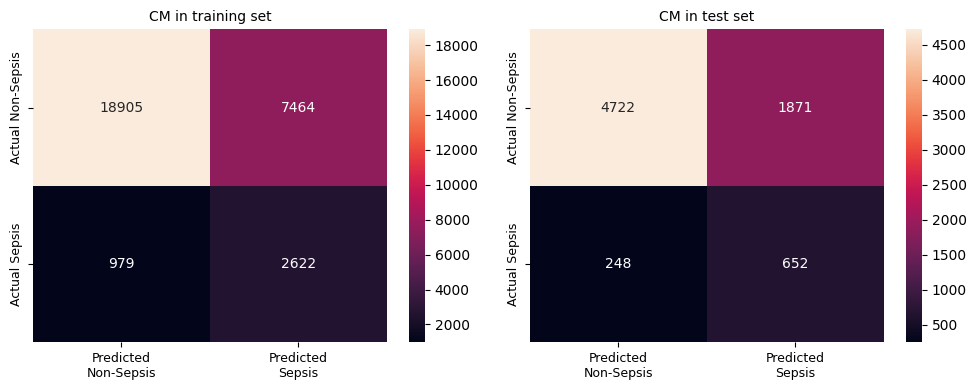

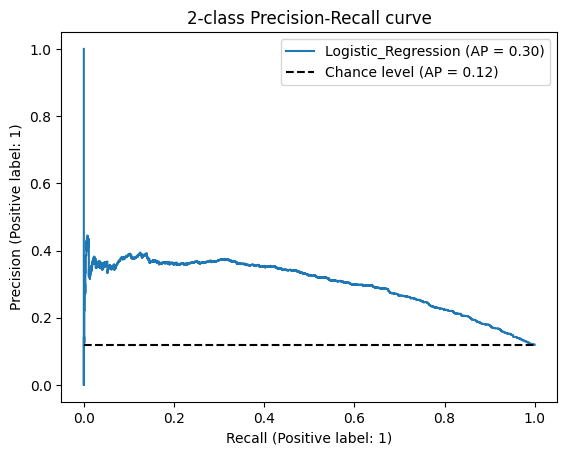

Logistic_Regression AUC : 0.7760


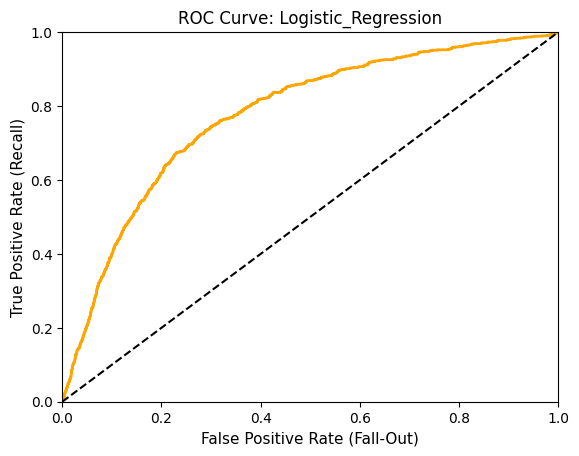

<Figure size 600x600 with 0 Axes>

Random_Forest
 ---------------------------------------- 


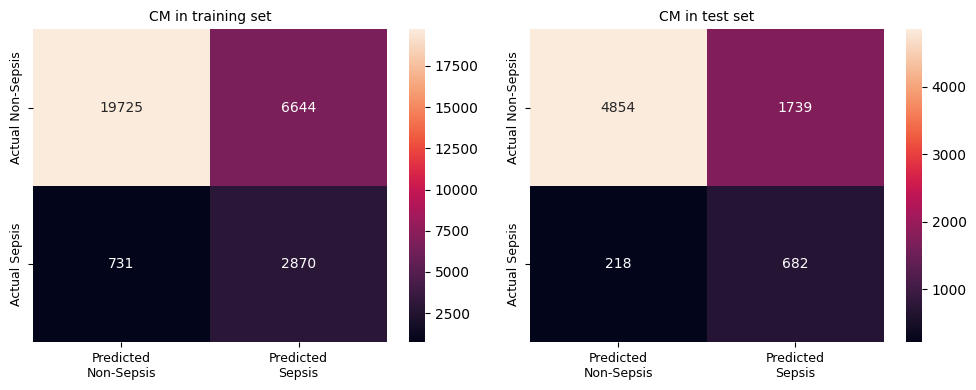

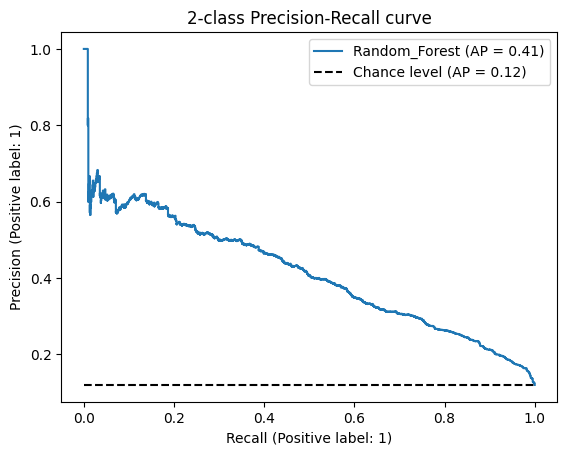

Random_Forest AUC : 0.8281


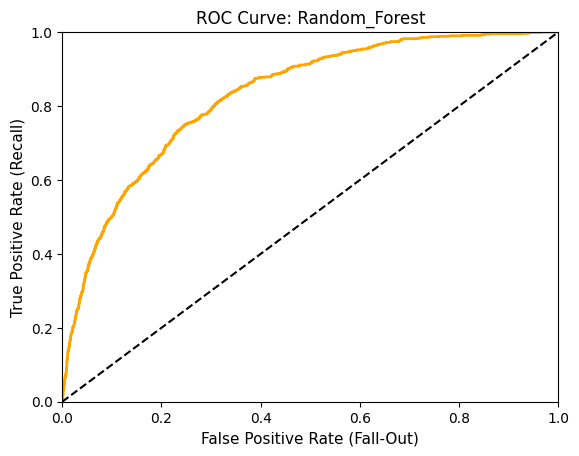

<Figure size 600x600 with 0 Axes>

Gradient_Boosting
 ---------------------------------------- 


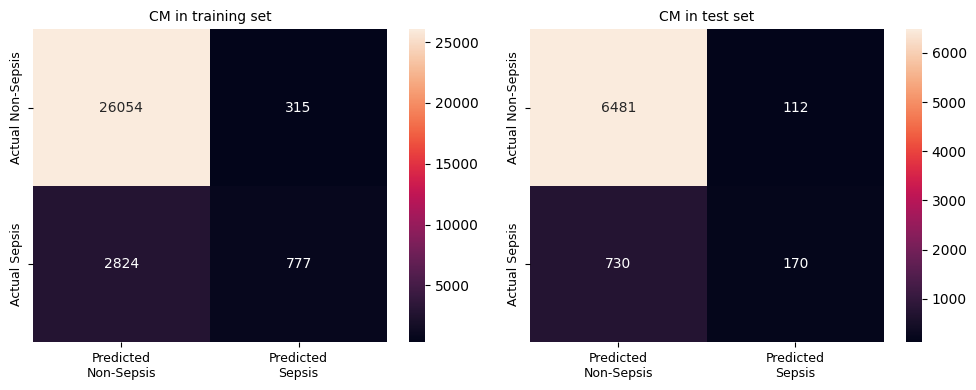

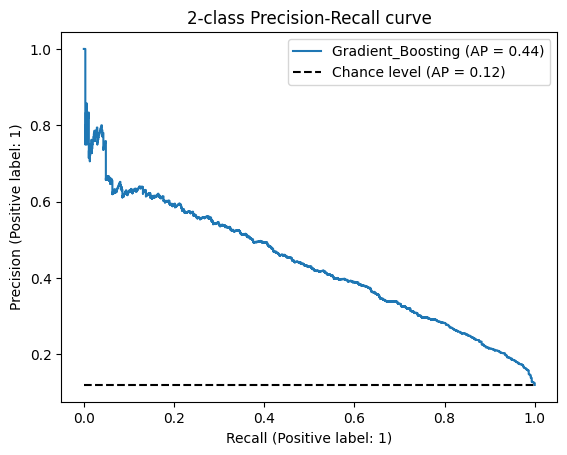

Gradient_Boosting AUC : 0.8383


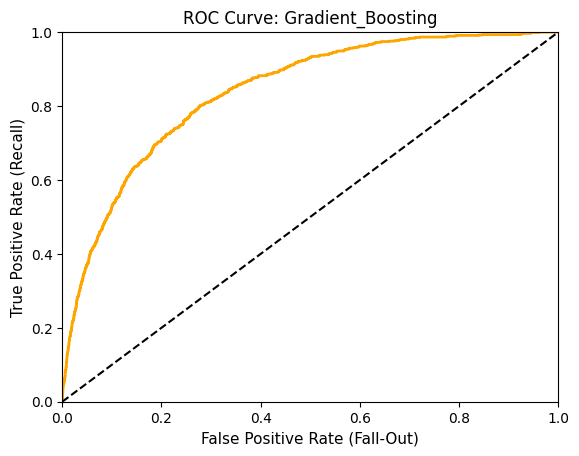

<Figure size 600x600 with 0 Axes>

In [31]:
# Visualise the model performance
mp.plot_results(final_candidate_model, top20_t2_class_weights, final_X_train, final_X_test, final_y_train, final_y_test)

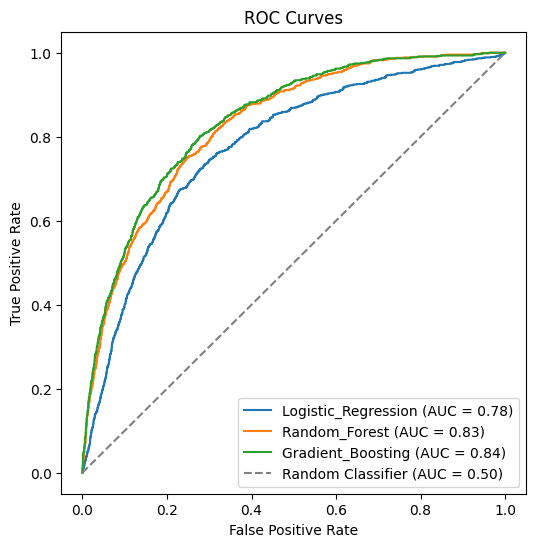

In [32]:
mp.plot_combined_roc_curves(final_candidate_model, final_X_test, final_y_test)

## 7. Feature Importance

### 7.1 SHAP

In [33]:
target_column = ["IS_SEPSIS"]
feature_columns = dfs_dict_without_missing['top20']['t2'].columns.drop("IS_SEPSIS").tolist()

# Convert 'ITEMID_' column to title
itemid_columns = [col for col in feature_columns if col.startswith('ITEMID_')]
title_mapping = dataLoader.convert_itemid_to_title(itemid_columns, df_desc_labitems)
for itemid, title in title_mapping.items():
    feature_columns[feature_columns.index(itemid)] = title

# Convert numpy array back to DataFrame
final_X_train_df = pd.DataFrame(final_X_train, columns=feature_columns)
final_y_train_df = pd.DataFrame(final_y_train, columns=target_column)
final_y_train_df = final_y_train_df.reset_index(drop=True)


final_X_test_df = pd.DataFrame(final_X_test, columns=feature_columns)
final_y_test_df = pd.DataFrame(final_y_test, columns=target_column)
final_y_test_df = final_y_test_df.reset_index(drop=True)

#### 7.1.1 Logistic Regression

##### 7.1.1.1 Global feature importance

In [35]:
explainer_lr = shap.LinearExplainer(final_candidate_model['Logistic_Regression'], final_X_train_df)
shap_values_lr = explainer_lr(final_X_test_df)

# set a display version of the data to use for plotting (has string values)
shap_values_lr.display_data = shap.datasets.adult(display=True)[0].values

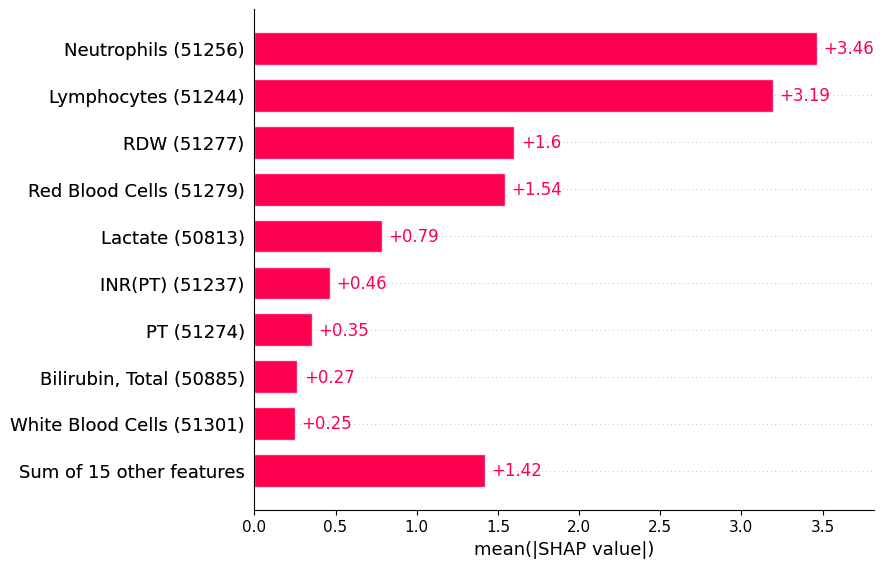

In [36]:
shap.plots.bar(shap_values_lr)

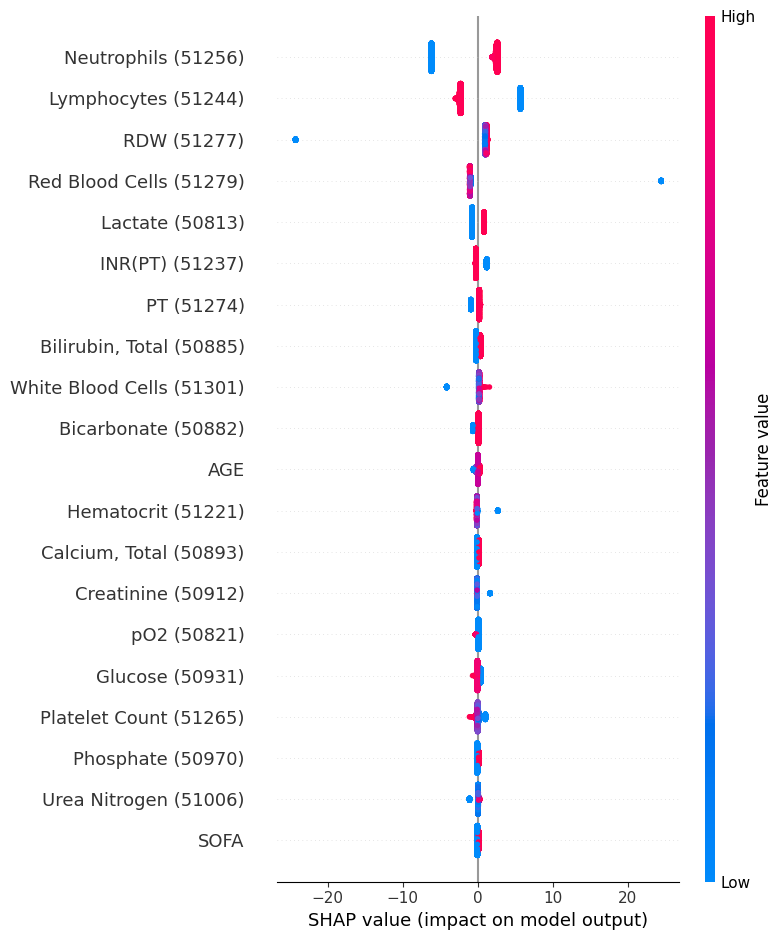

In [37]:
shap.summary_plot(shap_values_lr, final_X_test)

This plot shows the impact of each feature on the model output, as measured by SHAP value. The features are sorted from highest to lowest impact, so the most important features are at the top. The color of each bar indicates the impact on the model output, with red bars representing positive impacts and blue bars representing negative impacts.

- Positive impact: A feature has a positive impact on the model output if it increases the predicted value of the model.
- Negative impact: A feature has a negative impact on the model output if it decreases the predicted value of the model.

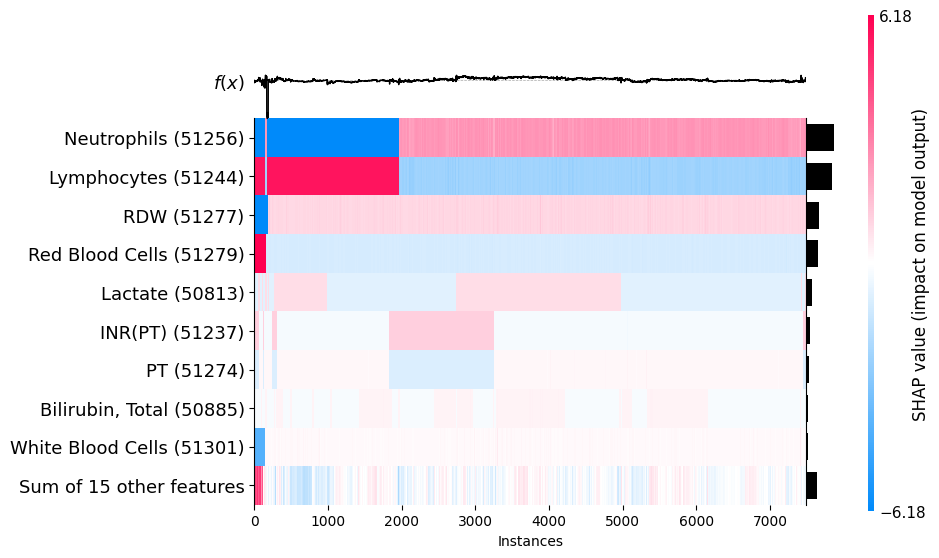

In [39]:
shap.plots.heatmap(shap_values_lr[:])

##### 7.1.1.2 Local Feature Importance

Sepsis Admission

In [38]:
# This will return a Series of boolean values (True where the condition is met, False otherwise)
condition = final_y_test_df['IS_SEPSIS'] == 1

# Display the indices where the condition is met
positive_indices = final_y_test_df[condition].index
print(positive_indices)

Index([   7,   17,   22,   30,   46,   51,   54,   56,   59,   69,
       ...
       7438, 7443, 7445, 7450, 7452, 7456, 7468, 7479, 7486, 7492],
      dtype='int64', length=900)


In [71]:
true_label_instance_1 = final_y_test_df.iloc[22]
print(true_label_instance_1)

IS_SEPSIS    1
Name: 22, dtype: int64


In [72]:
#22
individual_instance_1 = final_X_test_df.loc[[22]]
shap_values_lr_ind_1 = explainer_lr(individual_instance_1)
shap.initjs()
shap.force_plot(shap_values_lr_ind_1)

In [57]:
true_label_instance_2 = final_y_test_df.iloc[7468]
print(true_label_instance_2)

IS_SEPSIS    1
Name: 7468, dtype: int64


In [58]:
individual_instance_2 = final_X_test_df.loc[[7468]]
shap_values_lr_ind_2 = explainer_lr(individual_instance_2)
shap.initjs()
shap.force_plot(shap_values_lr_ind_2)

Non-Sepsis Admission

In [59]:
true_label_instance_3 = final_y_test_df.iloc[1314]
print(true_label_instance_3)

IS_SEPSIS    0
Name: 1314, dtype: int64


In [60]:
individual_instance_3 = final_X_test_df.loc[[1314]]
shap_values_lr_ind_3 = explainer_lr(individual_instance_3)
shap.initjs()
shap.force_plot(shap_values_lr_ind_3)

In [75]:
true_label_instance_4 = final_y_test_df.iloc[4782]
print(true_label_instance_4)

IS_SEPSIS    0
Name: 4782, dtype: int64


In [76]:
individual_instance_4 = final_X_test_df.loc[[4782]]
shap_values_lr_ind_4 = explainer_lr(individual_instance_4)
shap.initjs()
shap.force_plot(shap_values_lr_ind_4)

#### 7.1.2 Random Forest

##### 7.1.2.1 Global Feature Importance

In [40]:
explainer_rf = shap.TreeExplainer(final_candidate_model['Random_Forest']) 
shap_values_rf = explainer_rf.shap_values(final_X_test_df) 

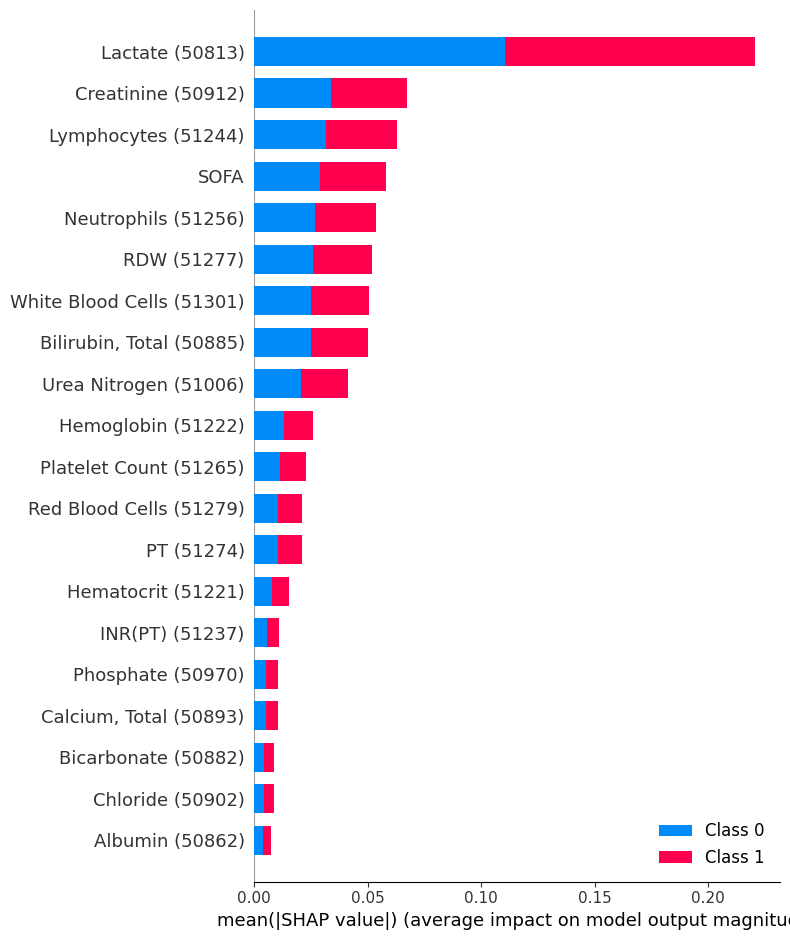

In [41]:
shap.summary_plot(shap_values_rf, final_X_test_df)

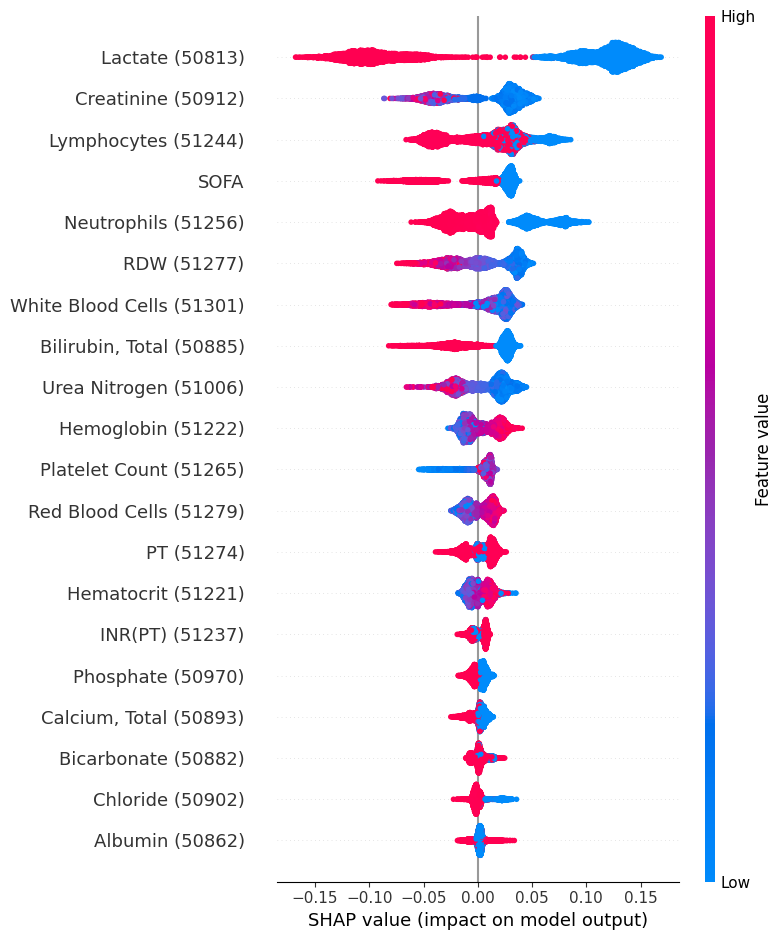

In [42]:
shap.summary_plot(shap_values_rf[0], final_X_test_df)

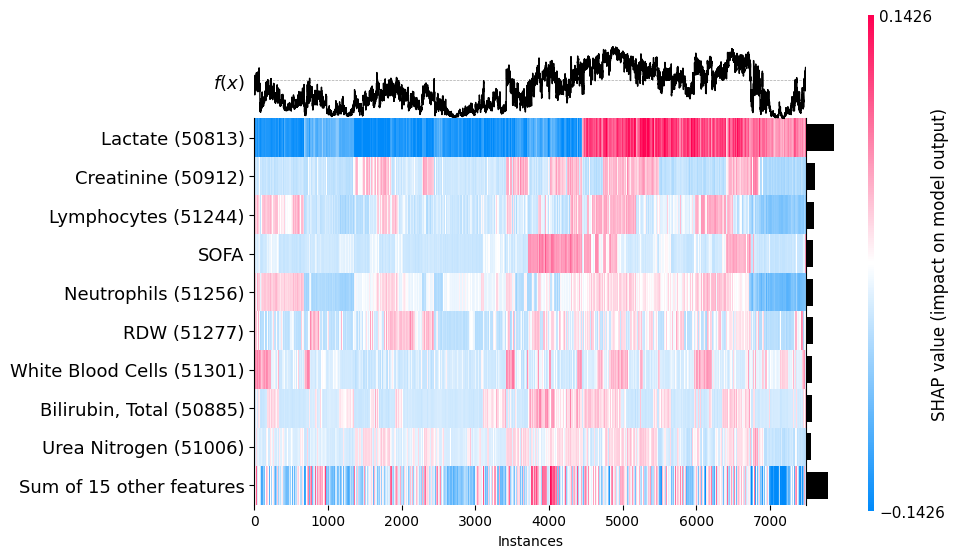

In [43]:
# Commented owing to significant time required to process (75min)
# shap_values_rf_subset = explainer_rf(final_X_test_df.iloc[:])
# shap.plots.heatmap(shap_values_rf_subset[:, :, 1])

##### 7.1.2.2 Local Feature Importance

Sepsis Admission

In [73]:
shap_values_rf_ind_1 = explainer_rf.shap_values(individual_instance_1)
shap.initjs()
shap.force_plot(explainer_rf.expected_value[1], shap_values_rf_ind_1[1], individual_instance_1)

In [64]:
shap_values_rf_ind_2 = explainer_rf.shap_values(individual_instance_2)
shap.initjs()
shap.force_plot(explainer_rf.expected_value[1], shap_values_rf_ind_2[1], individual_instance_2)

Non-spesis Admission

In [65]:
shap_values_rf_ind_3 = explainer_rf.shap_values(individual_instance_3)
shap.initjs()
shap.force_plot(explainer_rf.expected_value[1], shap_values_rf_ind_3[1], individual_instance_3)

In [77]:
shap_values_rf_ind_4 = explainer_rf.shap_values(individual_instance_4)
shap.initjs()
shap.force_plot(explainer_rf.expected_value[1], shap_values_rf_ind_4[1], individual_instance_4)

#### 7.1.3 Gradient Boosting

##### 7.1.3.1 Global Feature Importance

In [44]:
# compute SHAP values
explainer_gb = shap.TreeExplainer(final_candidate_model['Gradient_Boosting'])
shap_values_gb = explainer_gb(final_X_test_df)

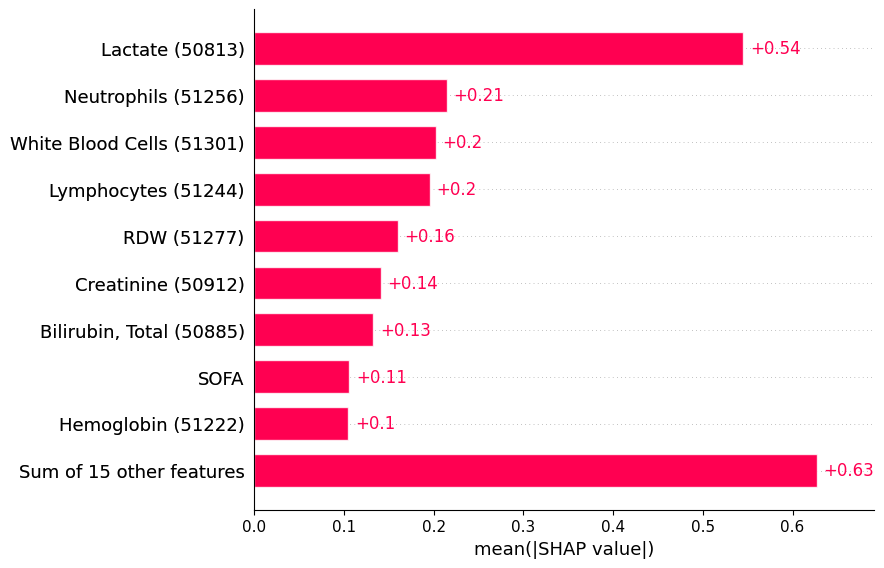

In [45]:
shap.plots.bar(shap_values_gb)

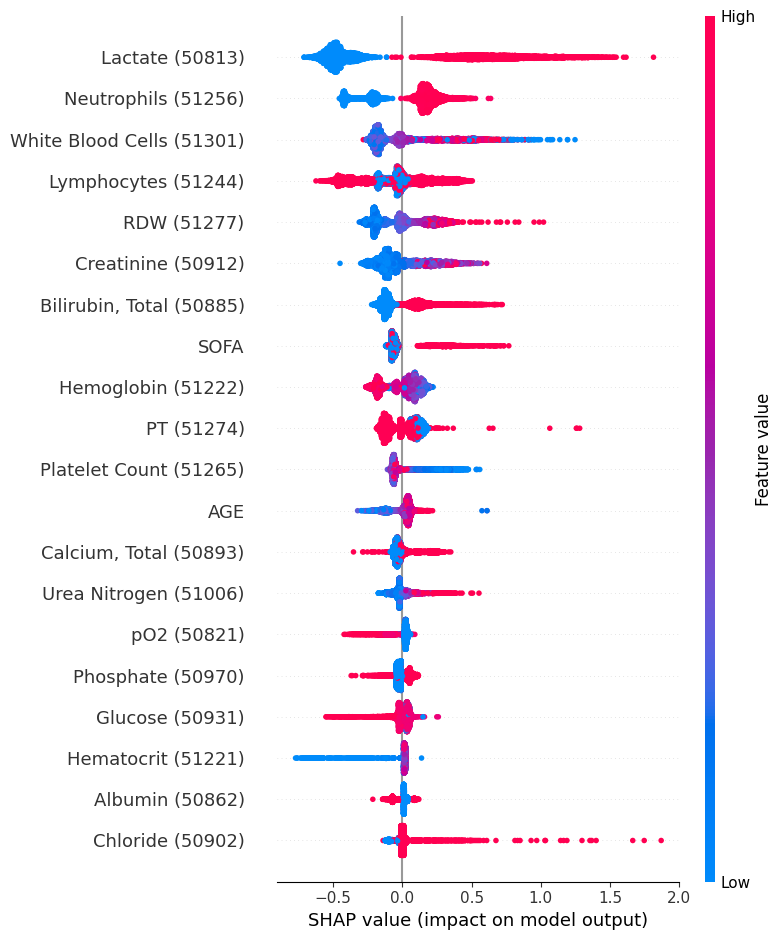

In [46]:
shap.summary_plot(shap_values_gb, final_X_test_df)

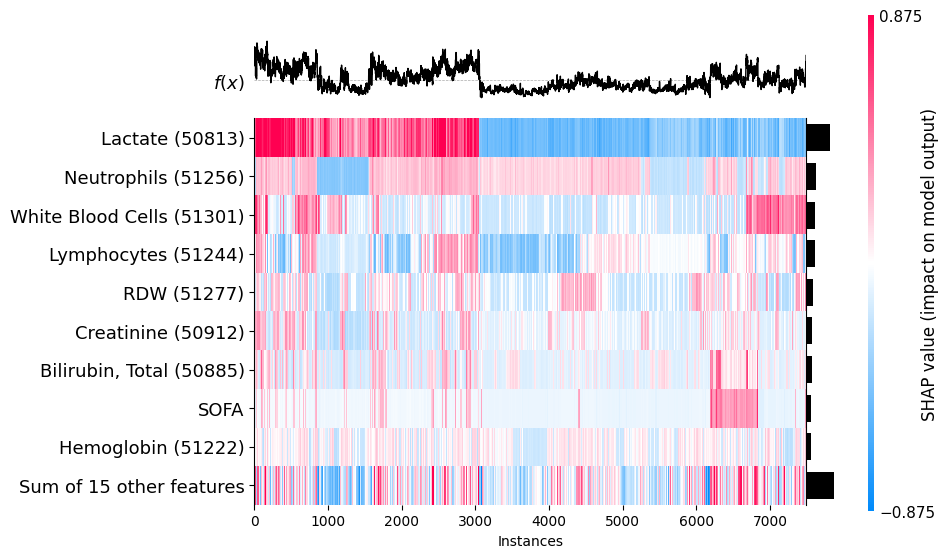

In [47]:
shap.plots.heatmap(shap_values_gb[:])

##### 7.1.3.2 Local Feature Importance

Sepsis Admission

In [74]:
shap_values_gb_ind_1 = explainer_gb(individual_instance_1)
shap.initjs()
shap.force_plot(shap_values_gb_ind_1)

In [68]:
shap_values_gb_ind_2 = explainer_gb(individual_instance_2)
shap.initjs()
shap.force_plot(shap_values_gb_ind_2)

Non-Sepsis Admission

In [69]:
shap_values_gb_ind_3 = explainer_gb(individual_instance_3)
shap.initjs()
shap.force_plot(shap_values_gb_ind_3)

In [78]:
shap_values_gb_ind_4 = explainer_gb(individual_instance_4)
shap.initjs()
shap.force_plot(shap_values_gb_ind_4)

## 11. Conclusion

Traditonal ML models trained with top 20 features at time window t2 were considered to be the final models, while Random Forest algorithm performed the best across the three traditional ML algorithms we applied in this project.

For more details in Traditional Machine Learning models training, please refer to file "003a_TradML.ipynb".

## 12. Copy Final Fitted Traditonal ML models (for reproduce propose)

In [112]:
filename_lr = 'finalised_LR_model.sav'
pickle.dump(final_candidate_model['Logistic_Regression'], open(filename_lr, 'wb'))

filename_rf = 'finalised_RF_model.sav'
pickle.dump(final_candidate_model['Random_Forest'], open(filename_rf, 'wb'))

filename_gb = 'finalised_GB_model.sav'
pickle.dump(final_candidate_model['Gradient_Boosting'], open(filename_gb, 'wb'))


# PART II. Deep Learning

## Loading neccessary libraries

In [58]:
import keras
import tensorflow as tf
from keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import LSTM, Input, GRU, Masking
from keras.models import Sequential, Model
from sklearn.model_selection import  train_test_split
from tensorflow.keras.utils import to_categorical

import numpy as np
from keras.models import Sequential

2023-10-22 09:36:42.695140: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-22 09:36:42.718009: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-22 09:36:43.186130: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Loading Data

The following files are needed to extract training data

In [ ]:
df_desc_icd, df_desc_labitems, df_desc_items = dataLoader.load_descriptions()
df_diagnoses_icd = dataLoader.load_diagnoses_icd(df_desc_icd)
df_demographic = dataLoader.load_demographic(df_diagnoses_icd)
df_demographic = dataLoader.demographic_clean_AGE(df_demographic)
df_labevents = dataLoader.load_labevents(df_demographic)
df_labevents = dataLoader.labevents_compute_TIME(df_labevents, df_demographic)

## Data Extraction

In [69]:
hours_list = [8]
top_n_features = [20]
dfs_dict = {}

The code below extract data by top n features and time t and save them into the folder. To save time, the files are uploaded and will be loaded for training the model

In [70]:
for top_n in top_n_features:
  dfs_dict[f'top{top_n}'] = {}
  for hour in hours_list:
    feature_filename=ROOT_DIR / 'data/potential_events.csv'
    output_filename = ROOT_DIR / f'data/Model input data/t{hour}_top{top_n}_sequence.csv'
    try:
      extracted_df = pd.read_csv(output_filename)
    except:
      extracted_df = dataLoader.create_train_data_sequence_new(df_labevents, df_demographic, df_desc_labitems, hours=hour, feature_no=top_n, output_filename = output_filename)
    extracted_df['CHARTTIME'] = pd.to_datetime(extracted_df['CHARTTIME'], format='%Y-%m-%d %H:%M:%S')
    dfs_dict[f'top{top_n}'][f't{hour}'] = extracted_df

# Model Fitting

## Data preparation

In [71]:
top_features = [f'top{i}' for i in top_n_features] 
time_windows = [f't{i}' for i in hours_list]

In [72]:
from sklearn.impute import SimpleImputer

def df_split(X, Y, test_size):
    x_train, x_test, y_train, y_test = train_test_split(
        X,  # dropping the target column for X values
        Y,
        test_size=test_size,  # this means 20% test set
        stratify=Y,  # stratify by the target variable
        random_state=42  # to ensure reproducibility
        )
    return x_train, x_test, y_train, y_test

def create_data_df(full_df, splitted_df):
    x_df = full_df.merge(splitted_df[['SUBJECT_ID', 'HADM_ID']])
    x_df['count'] = x_df.groupby(['SUBJECT_ID', 'HADM_ID'])['HADM_ID'].transform('count')
    x_count = x_df.drop_duplicates(['SUBJECT_ID', 'HADM_ID'])['count']
    y_df = x_df.drop_duplicates(['SUBJECT_ID', 'HADM_ID'])['IS_SEPSIS']
    return x_df, x_count, y_df

def preprocess_data(x_train_df, x_test_df, x_val_df):
    imputer = SimpleImputer(strategy='median', missing_values=np.nan)

    train_gendernum = x_train_df.GENDER_NUM.values #take out the column doesn't need to scale
    test_gendernum = x_test_df.GENDER_NUM.values
    val_gendernum = x_val_df.GENDER_NUM.values

    # impute X
    x_train = imputer.fit_transform(x_train_df.drop(["SUBJECT_ID", "HADM_ID", 'IS_SEPSIS', 'CHARTTIME', 'count', 'GENDER_NUM'], axis=1))
    x_test = imputer.transform(x_test_df.drop(["SUBJECT_ID", "HADM_ID", 'IS_SEPSIS', 'CHARTTIME', 'count', 'GENDER_NUM'], axis=1))
    x_val = imputer.transform(x_val_df.drop(["SUBJECT_ID", "HADM_ID", 'IS_SEPSIS', 'CHARTTIME', 'count', 'GENDER_NUM'], axis=1))

    # Feature scaling - Standardisation
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train) #scale X
    x_test = scaler.transform(x_test)
    x_val = scaler.transform(x_val)

    x_train = np.column_stack((x_train, train_gendernum)) #merge the columns doesn't need to scale back to X
    x_test = np.column_stack((x_test, test_gendernum))
    x_val = np.column_stack((x_val, val_gendernum))

    return x_train, x_test, x_val

def ts_to_secs(X, X_count, Y):
    secs_data = tf.RaggedTensor.from_row_lengths(X, X_count)
    act_secs_labels = to_categorical(Y)
    return secs_data, act_secs_labels

def data_preparation(x_train, x_train_count, y_train_df, 
                     x_test, x_test_count, y_test_df,
                     x_val, x_val_count, y_val_df):
  train_data, act_train = ts_to_secs(x_train, x_train_count, y_train_df)
  test_data, act_test = ts_to_secs(x_test, x_test_count, y_test_df)
  val_data, act_val = ts_to_secs(x_val, x_val_count, y_val_df)

  # Here we add an extra dimension to the datasets just to be ready for using with Convolution2D
  print("[INFO] -- Shape of Training Sections:")
  print(train_data.bounding_shape())
  print("[INFO] -- Shape of Test Sections:")
  print(test_data.bounding_shape())
  print("[INFO] -- Shape of Validation Sections:")
  print(val_data.bounding_shape())

  return train_data, act_train, test_data, act_test, val_data, act_val

In [73]:
split_df_dict_lstm = {}
split_data_dict_lstm = {}

for top in top_features:
    dfs_list = []
    
    for time in time_windows:
        df_data = dfs_dict[top][time]
        admission = df_data[['SUBJECT_ID', 'HADM_ID', 'IS_SEPSIS']].drop_duplicates(["SUBJECT_ID", "HADM_ID"])

        x_train_df, x_test_df, y_train_df, _ = df_split(admission.drop('IS_SEPSIS', axis=1),  # dropping the target column for X values
                                                        admission['IS_SEPSIS'],
                                                        test_size=0.2,
                                                        )

        x_train_df, x_val_df, _, _ = df_split(x_train_df,  # dropping the target column for X values
                                                y_train_df,
                                                test_size=0.15,
                                                )

        x_train_df, x_train_count, y_train_df = create_data_df(df_data, x_train_df)
        x_test_df, x_test_count, y_test_df = create_data_df(df_data, x_test_df)
        x_val_df, x_val_count, y_val_df = create_data_df(df_data, x_val_df)

        # impute missing value and standardized data
        x_train, x_test, x_val = preprocess_data(x_train_df, x_test_df, x_val_df)
        x_train, y_train, x_test, y_test, x_val, y_val = data_preparation(
            x_train, x_train_count, y_train_df, 
            x_test, x_test_count, y_test_df,
            x_val, x_val_count, y_val_df)
        
        # Store split dataframe
        split_df_dict_lstm[(top, time)] = {'x_train_df': x_train_df, 'x_test_df': x_test_df, 'x_val_df': x_val_df, 'y_train_df': y_train_df, 'y_test_df': y_test_df, 'y_val_df': y_val_df}
        # Store split data
        split_data_dict_lstm[(top, time)] = {'x_train': x_train, 'x_test': x_test, 'y_train': y_train, 'y_test': y_test, 'x_val': x_val, 'y_val': y_val}

[INFO] -- Shape of Training Sections:
tf.Tensor([32800    21    24], shape=(3,), dtype=int64)
[INFO] -- Shape of Test Sections:
tf.Tensor([9648   18   24], shape=(3,), dtype=int64)
[INFO] -- Shape of Validation Sections:
tf.Tensor([5789   17   24], shape=(3,), dtype=int64)


## Model Definition

In [76]:
reload(models)
METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.AUC(name='auc'),
]

model_hist_dict = {}
models_dict = {}

In [77]:
from keras.optimizers import schedules
from keras.callbacks import LearningRateScheduler
import math

init_lr = 0.001

def scheduler(epoch):
  return init_lr * tf.math.exp(-0.1 * epoch)
lr_scheduler = LearningRateScheduler(scheduler)

In [78]:
def LSTM_model(x_train):
    feat_no = x_train[0][0].shape[0]
    d = 0.25
    model=Sequential()
    model.add(Input(shape=[None, feat_no], dtype=tf.float32, ragged=True))
    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(Dropout(d))
    model.add(LSTM(64))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='sigmoid'))

    return model

In [38]:
for top in top_features:
  model_hist_dict[top] = {}
  for time in time_windows:
    print(f"----------------Start model {top}, {time}---------------------")

    x_train = split_data_dict_lstm[(top, time)]['x_train']
    y_train = split_data_dict_lstm[(top, time)]['y_train']
    x_test = split_data_dict_lstm[(top, time)]['x_test']
    y_test = split_data_dict_lstm[(top, time)]['y_test']
    x_val = split_data_dict_lstm[(top, time)]['x_val']
    y_val = split_data_dict_lstm[(top, time)]['y_val']

    model = LSTM_model(x_train)
    model.summary()
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=init_lr), loss='binary_crossentropy', metrics = METRICS)

    checkpointer = ModelCheckpoint(filepath = f'models/LSTM_{top}_{time}_model.hdf5', save_best_only = True, monitor='val_accuracy', mode='max')
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience=10, restore_best_weights=True)
    callbacks_list = [lr_scheduler, early_stop, checkpointer]
    
    sample_weights = mp.compute_sample_weights(y_train[:,1].astype(int))

    m = model.fit(x_train,y_train,
                  sample_weight=sample_weights,
                  # class_weight=me.get_class_weights(y_train_df),
                  epochs=50, batch_size=64, verbose=1,
                  validation_data=(x_val, y_val),
                  callbacks=callbacks_list)
    model_hist_dict[top][time] = m

----------------Start model top20, t8---------------------
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, None, 64)          22784     
                                                                 
 dropout_14 (Dropout)        (None, None, 64)          0         
                                                                 
 lstm_15 (LSTM)              (None, 64)                33024     
                                                                 
 dropout_15 (Dropout)        (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 2)                 130       
                                                                 
Total params: 55938 (218.51 KB)
Trainable params: 55938 (218.51 KB)
Non-trainable params: 0 (0.00 Byte)
_______________________

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


513/513 [==============================] - 6s 12ms/step - loss: 0.5388 - accuracy: 0.7680 - auc: 0.8028 - val_loss: 0.5705 - val_accuracy: 0.7506 - val_auc: 0.7826 - lr: 9.0484e-04
Epoch 3/50
513/513 [==============================] - 6s 12ms/step - loss: 0.5244 - accuracy: 0.7702 - auc: 0.8163 - val_loss: 0.5043 - val_accuracy: 0.7773 - val_auc: 0.8347 - lr: 8.1873e-04
Epoch 4/50
513/513 [==============================] - 6s 12ms/step - loss: 0.5140 - accuracy: 0.7681 - auc: 0.8233 - val_loss: 0.5061 - val_accuracy: 0.7684 - val_auc: 0.8308 - lr: 7.4082e-04
Epoch 5/50
513/513 [==============================] - 6s 12ms/step - loss: 0.5082 - accuracy: 0.7691 - auc: 0.8311 - val_loss: 0.5226 - val_accuracy: 0.7586 - val_auc: 0.8189 - lr: 6.7032e-04
Epoch 6/50
513/513 [==============================] - 6s 12ms/step - loss: 0.5040 - accuracy: 0.7677 - auc: 0.8315 - val_loss: 0.5190 - val_accuracy: 0.7623 - val_auc: 0.8223 - lr: 6.0653e-04
Epoch 7/50
513/513 [==============================]

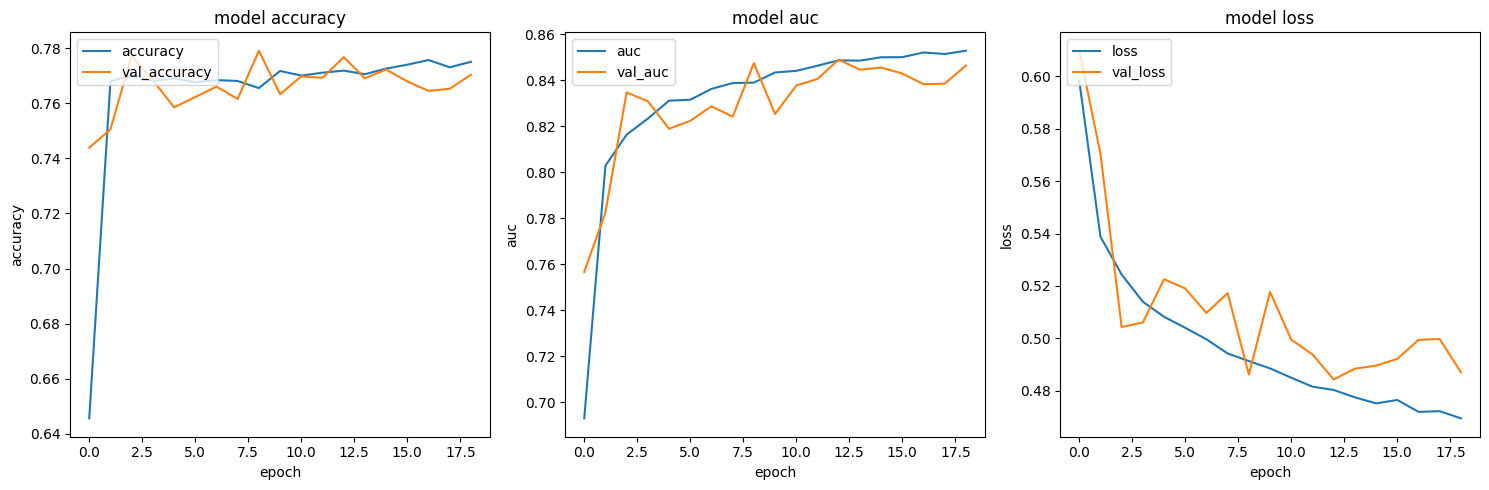

In [40]:
import matplotlib.pyplot as plt

for top in top_features:
  for time in time_windows:
    # Create a figure with two subplots side by side
    fig, (plt1, plt2, plt3) = plt.subplots(1, 3, figsize=(15, 5))
    m_hist = model_hist_dict[top][time]
    
    # plt.plot(m.history['loss'])
    plt1.plot(m_hist.history['accuracy'])
    plt1.plot(m_hist.history['val_accuracy'])
    plt1.set_title('model accuracy')
    plt1.set_ylabel('accuracy')
    plt1.set_xlabel('epoch')
    plt1.legend(['accuracy', 'val_accuracy'], loc='upper left')

    # plt.plot(m.history['loss'])
    plt2.plot(m_hist.history['auc'])
    plt2.plot(m_hist.history['val_auc'])
    plt2.set_title('model auc')
    plt2.set_ylabel('auc')
    plt2.set_xlabel('epoch')
    plt2.legend(['auc', 'val_auc'], loc='upper left')

    # plt.plot(m.history['loss'])
    plt3.plot(m_hist.history['loss'])
    plt3.plot(m_hist.history['val_loss'])
    plt3.set_title('model loss')
    plt3.set_ylabel('loss')
    plt3.set_xlabel('epoch')
    plt3.legend(['loss', 'val_loss'], loc='upper left')

    plt.tight_layout()
    plt.show()

302/302 [==============================] - 1s 4ms/step


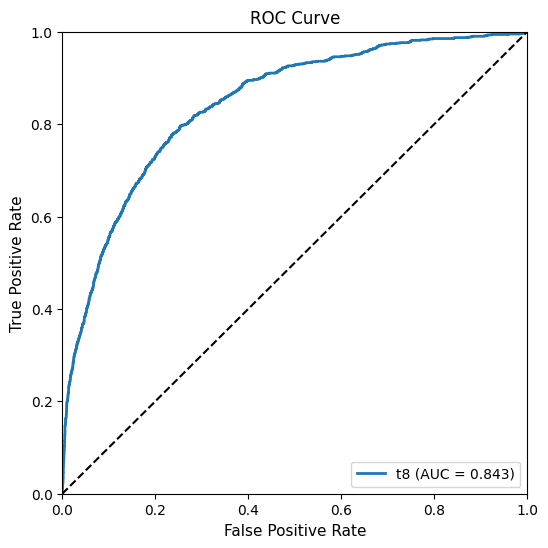

Model  Balanced acc Train  Balanced acc Test  Precision Train  \
0    t8               0.766              0.767            0.296   

   Precision Test  Recall Train  Recall Test  F1 Train  F1 Test    AUC  
0           0.293         0.741        0.746     0.422    0.421  0.843

In [96]:
from keras.models import load_model

trained_models = {}
for top in top_features:
  trained_models[top] = {}
  for time in time_windows:  
    model = load_model(f'models/LSTM_{top}_{time}_model.hdf5')
    trained_models[top][time] = model

mp.plot_combined_roc_curves_lstm(trained_models, split_data_dict_lstm, top_features, time_windows)

  23/1025 [..............................] - ETA: 4s

302/302 [==============================] - 1s 4ms/step
***[RESULT]*** ACT  Confusion Matrix


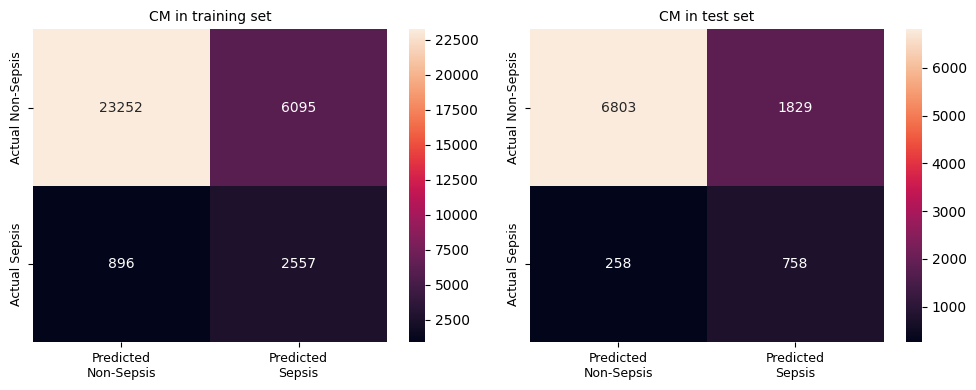

F1-Score  Balanced Acc  Precision    Recall
Train   0.42247      0.766414   0.295539  0.740515
Test    0.42076      0.767088   0.293003  0.746063

In [80]:
top = 'top20'
time = 't8'
x_train = split_data_dict_lstm[(top, time)]['x_train']
y_train = split_data_dict_lstm[(top, time)]['y_train']
x_test = split_data_dict_lstm[(top, time)]['x_test']
y_test = split_data_dict_lstm[(top, time)]['y_test']
mp.print_results(trained_models[top][time], x_train, y_train, x_test, y_test)

  1/302 [..............................] - ETA: 2s

302/302 [==============================] - 1s 4ms/step
Average Precision (AP): 0.4500


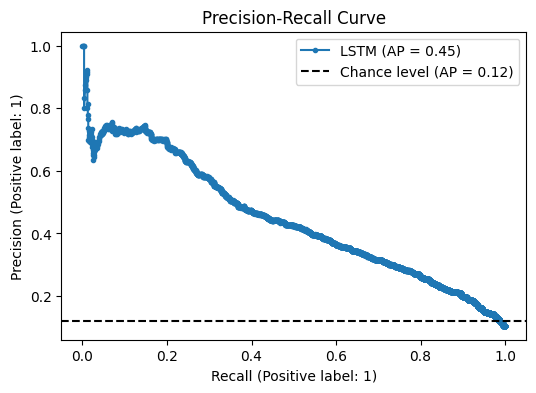

In [81]:
reload(models)
mp.plot_precision_recall_lstm(trained_models[top][time], 'LSTM', x_test, y_test)

## Combining tradition models and LSTM model performance

In [97]:
# load the model from disk
gb_model = pickle.load(open('Amy Hung/Final_model_copy/finalised_GB_model.sav', 'rb'))
lr_model = pickle.load(open('Amy Hung/Final_model_copy/finalised_LR_model.sav', 'rb'))
rf_model = pickle.load(open('Amy Hung/Final_model_copy/finalised_RF_model.sav', 'rb'))
lstm_model = load_model(f'models/LSTM_top20_t8_model.hdf5')
final_candidate_model = {
            'Logistic_Regression': lr_model,
            'Random_Forest': rf_model,
            'Gradient_Boosting': gb_model,
            'LSTM': lstm_model
        }

302/302 [==============================] - 1s 4ms/step


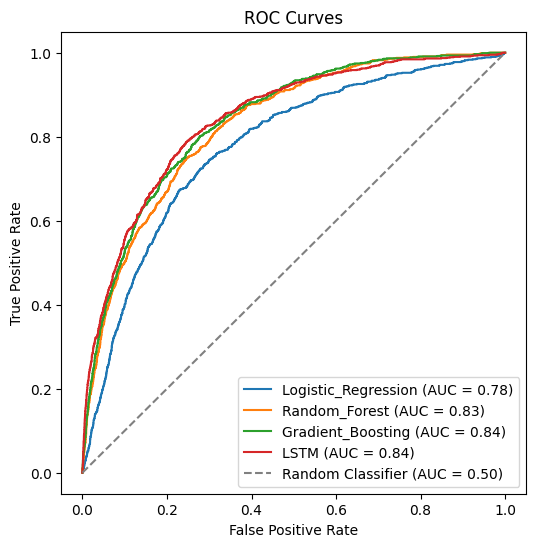

In [98]:
mp = models.ModelPipeline(ROOT_DIR)
mp.plot_combined_roc_curves(final_candidate_model, final_X_test, final_y_test, x_test, y_test)

# PART III. Survival Analysis